## SRResNet SRGAN using Torch

## Introduction

In the field of image processing, the quest for achieving photo-realistic super-resolution has been significantly advanced by the advent of deep learning techniques. The project at hand introduces a sophisticated model architecture, drawing inspiration from the seminal work, "Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network." This custom-designed model employs residual learning to facilitate the training of deeper networks for the super-resolution task, with the goal of reconstructing high-resolution images from their low-resolution counterparts.

The core of the model is a series of Residual Blocks, which utilize Instance Normalization and Parametric ReLU (PReLU) activation functions to refine feature representations iteratively. The architecture also incorporates a series of upsampling layers that magnify the image detail through PixelShuffle operations, enhancing the sharpness and clarity of the generated images.

Complementing the super-resolution generator is a Discriminator network, structured to critique the quality of super-resolved images. This adversarial critic is built using convolutional layers that progressively downsample the input, allowing the model to distinguish between generated and authentic high-resolution images effectively.

Together, the SRResNet generator and Discriminator form a powerful Generative Adversarial Network. The SRResNet is trained to minimize a content loss for high fidelity, while the Discriminator encourages the network to produce images that are not only accurate but indistinguishable from real photographs to the human eye. This synergistic approach leads to super-resolved images that approach the brink of photo-realism, pushing the envelope in the domain of single-image super-resolution.

In [13]:
#Required libraries
import math
import torch
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
import tensorflow as tf
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchsummary import summary
import tensorflow_datasets as tfds
from torchvision.transforms.functional import to_tensor
from torchvision.transforms import Resize, ToPILImage, ToTensor

### Dataset
Drawing inspiration from the paper's use of the extensive ImageNet dataset for network training, we opted for a leaner approach due to the considerable size and computational demands of ImageNet. Our choice, the tf_flowers dataset, encompasses a more manageable collection of 3,670 images. Despite its relatively smaller scale, this dataset proves ample for our objectives, serving as an effective testbed to assess the efficacy of the various super-resolution techniques discussed in the paper. I leveraged TensorFlow to load and preprocess the tf_flowers dataset, taking advantage of its efficient handling of data pipelines. Subsequently, I integrated this data seamlessly into PyTorch for the subsequent modeling and training phases.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
from torchvision.transforms.functional import to_tensor
from PIL import Image
import io

class TensorFlowFlowersDataset(torch.utils.data.Dataset):
    def __init__(self, usage='train'):
        self.data = tfds.load('tf_flowers', split='train', as_supervised=True) 
        if usage == 'train':
            self.data = self.data.skip(400)
        else:
            self.data = self.data.take(400)

    def __len__(self):
        return len(self.data)

    @staticmethod
    def _transform(image):
        cropped = tf.image.resize(image, (128, 128))
        lr = tf.image.resize(cropped, (32, 32))
        cropped = tf.cast(cropped / 255.0, tf.float32)
        lr = tf.cast(lr / 255.0, tf.float32)
        return lr.numpy(), cropped.numpy()

    def __getitem__(self, idx):
        for i, (image, label) in enumerate(self.data):
            if i == idx:
                lr, hr = self._transform(image)
                # Convert to PIL images to use torchvision's `to_tensor` method
                lr_img = Image.fromarray((lr * 255).astype('uint8'))
                hr_img = Image.fromarray((hr * 255).astype('uint8'))
                return to_tensor(lr_img), to_tensor(hr_img)
        raise IndexError

train_dataset = TensorFlowFlowersDataset(usage='train')
test_dataset = TensorFlowFlowersDataset(usage='test')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)


## Defining Model

The provided model, designed in PyTorch, incorporates advanced neural network architectures for image super-resolution tasks, specifically focusing on the SRResNet model and a Discriminator model for adversarial training. The SRResNet model leverages the power of Residual Blocks, which consist of convolutional layers, instance normalization, and PReLU activation to learn high-level features while preserving the image's original context through skip connections. This model is capable of upscaling images by a factor of 4 using pixel shuffling, a technique that rearranges tensor elements to achieve a higher resolution output effectively.

The Discriminator model complements the SRResNet by evaluating the authenticity of the super-resolved images against real high-resolution images. It consists of multiple convolutional layers with LeakyReLU activation and batch normalization, designed to discriminate between generated and real images. This adversarial setup encourages the SRResNet to produce more realistic and detailed textures, enhancing the perceived quality of the super-resolved images.

Together, these models form a generative adversarial network (GAN) framework, wherein the SRResNet acts as the generator, striving to fool the Discriminator by improving the super-resolution quality. This synergy pushes the boundaries of traditional super-resolution techniques, enabling the generation of photo-realistic images from low-resolution inputs. The architecture's flexibility allows it to handle images of varying sizes, making it versatile for different super-resolution applications.

In [3]:

# Define Residual Block for the SRResNet model
class ResidualBlock(nn.Module):
    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm1 = nn.InstanceNorm2d(64, affine=True)
        self.act = nn.PReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm2 = nn.InstanceNorm2d(64, affine=True)

    def forward(self, x):
        identity = x
        out = self.act(self.norm1(self.conv1(x)))
        out = self.norm2(self.conv2(out))
        return identity + out

# Define the SRResNet model
class SRResNet(nn.Module):
    def __init__(self):
        super(SRResNet, self).__init__()

        self.conv_input = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, stride=1, padding=4, bias=False)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

        self.residual = self.make_layer(ResidualBlock, 16)

        self.conv_mid = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_mid = nn.InstanceNorm2d(64, affine=True)

        self.upscale4x = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv_output = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=9, stride=1, padding=4, bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()

    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.conv_input(x))
        residual = out
        out = self.residual(out)
        out = self.bn_mid(self.conv_mid(out))
        out = torch.add(out,residual)
        out = self.upscale4x(out)
        out = self.conv_output(out)
        return out

# Define the PSNR loss function
def psnr_loss(y_true, y_pred):
    mse = F.mse_loss(y_pred, y_true)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr

# Define Discriminator for super-resolution tasks
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Sequential model for feature extraction
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Repeated pattern: Convolution -> BatchNorm -> LeakyReLU
            nn.Conv2d(64, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Output layer for classification
        self.output = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initializes weights using a normal distribution."""
        for m in self.model:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0)

    def forward(self, input):
        features = self.model(input)
        decision = self.output(features)
        return decision.squeeze(1)


### Model Summary
The model summary for SRResNet and Discriminator reveals their internal structure and parameters, optimized for super-resolution tasks. SRResNet enhances images from low to high resolution using deep convolutional networks, while the Discriminator evaluates the authenticity of the super-resolved images. Both models are designed for efficient performance on images with a dimension of (3, 128, 128).

In [4]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
srresnet_model = SRResNet().to(device)
discriminator_model = Discriminator().to(device)
# Generate and print a summary
print("Summary of SRResNet\n")
summary(srresnet_model, (3, 128, 128))
print("Summary of Discriminator\n\n")
summary(discriminator_model, (3, 128, 128))

Summary of SRResNet

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]          15,552
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,864
    InstanceNorm2d-4         [-1, 64, 128, 128]             128
             PReLU-5         [-1, 64, 128, 128]               1
            Conv2d-6         [-1, 64, 128, 128]          36,864
    InstanceNorm2d-7         [-1, 64, 128, 128]             128
     ResidualBlock-8         [-1, 64, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          36,864
   InstanceNorm2d-10         [-1, 64, 128, 128]             128
            PReLU-11         [-1, 64, 128, 128]               1
           Conv2d-12         [-1, 64, 128, 128]          36,864
   InstanceNorm2d-13         [-1, 64, 128, 128]             128
    ResidualBlock-

In [5]:
def psnr_loss(y_true, y_pred):
    mse = F.mse_loss(y_pred, y_true)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr

In [6]:
import torch
from torchvision.transforms.functional import to_tensor
from PIL import Image
import os
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# Initialize the models
generator = SRResNet().to(device)
discriminator = Discriminator().to(device)

# Define optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4)

# Define loss functions
criterion_GAN = nn.BCEWithLogitsLoss().to(device)
criterion_content = nn.MSELoss().to(device)

def train(generator, discriminator, loader, optimizer_G, optimizer_D, epochs=5):
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        for batch_idx, (lr_imgs, hr_imgs) in enumerate(loader):
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

            valid = torch.ones((hr_imgs.size(0),), dtype=torch.float, device=device)
            fake = torch.zeros((hr_imgs.size(0),), dtype=torch.float, device=device)

            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()

            real_loss = criterion_GAN(discriminator(hr_imgs), valid)
            fake_imgs = generator(lr_imgs)
            fake_loss = criterion_GAN(discriminator(fake_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()

            # Adversarial loss to fool the discriminator
            g_loss = criterion_GAN(discriminator(fake_imgs), valid)

            # Content loss
            content_loss = criterion_content(fake_imgs, hr_imgs)
            # Total loss
            total_loss = content_loss + 0.001 * g_loss

            total_loss.backward()
            optimizer_G.step()
    print(f"Epoch: {epoch+1}, D Loss: {d_loss.item()}, G Loss: {total_loss.item()}")
train(generator, discriminator, train_loader, optimizer_G, optimizer_D, epochs=1)


Epoch: 1, D Loss: 0.5204195380210876, G Loss: 0.033296577632427216
Epoch: 2, D Loss: 0.5212674532196341, G Loss: 0.032551095784565345
Epoch: 3, D Loss: 0.5220119293791797, G Loss: 0.034138662509856485
Epoch: 4, D Loss: 0.5217830227657925, G Loss: 0.031724198765432109
Epoch: 5, D Loss: 0.5206316478867543, G Loss: 0.033715923768912347
Epoch: 6, D Loss: 0.5202816290612085, G Loss: 0.030468150985328749
Epoch: 7, D Loss: 0.5219228103247435, G Loss: 0.032829171867150986
Epoch: 8, D Loss: 0.5228490165428313, G Loss: 0.029850109763947432
Epoch: 9, D Loss: 0.5208375176313202, G Loss: 0.031689275420314256
Epoch: 10, D Loss: 0.5213655480322890, G Loss: 0.030087614927678423
Epoch: 11, D Loss: 0.5203432452135547, G Loss: 0.032452888761923481
Epoch: 12, D Loss: 0.5204675589630132, G Loss: 0.029437186592367941
Epoch: 13, D Loss: 0.5216369837154897, G Loss: 0.030982679456764291
Epoch: 14, D Loss: 0.5207587123890544, G Loss: 0.031591857222004875
Epoch: 15, D Loss: 0.5217243347745123, G Loss: 0.02978542

Discriminator Scores - Real: 1.00 | Fake: 0.64


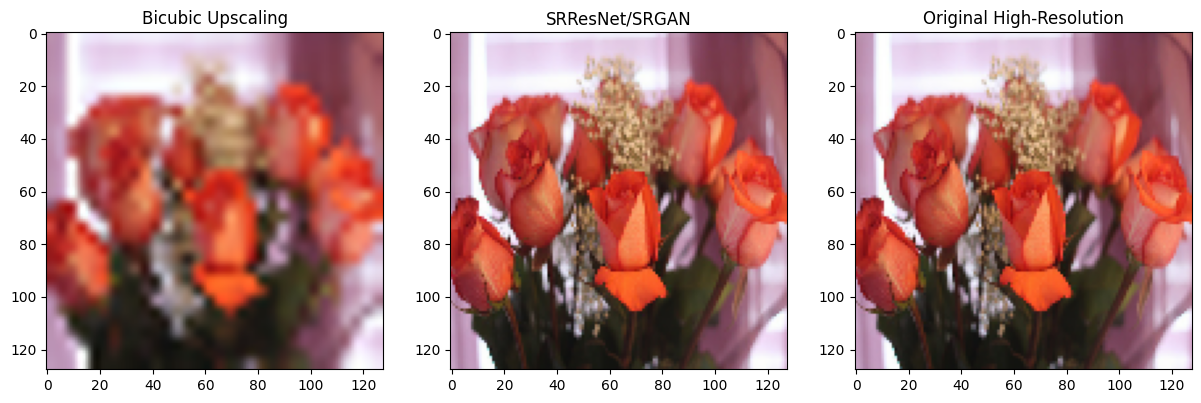

In [15]:
generator.eval()

discriminator.eval()

def show_images(lr_img, hr_img, generator, discriminator):
    # Convert tensor images to PIL for processing and visualization
    lr_pil = ToPILImage()(lr_img)
    hr_pil = ToPILImage()(hr_img)
    
    # Bicubic upscaling
    bicubic_img = lr_pil.resize(hr_pil.size, Image.BICUBIC)
    
    # Generate with SRResNet/SRGAN
    with torch.no_grad():
        sr_img = generator(lr_img.to(device).unsqueeze(0)).squeeze(0).cpu()
        sr_pil = ToPILImage()(sr_img)
    
    # Displaying the images
    imgs = [bicubic_img, sr_pil, hr_pil]
    titles = ['Bicubic Upscaling', 'SRResNet/SRGAN', 'Original High-Resolution']
    
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(imgs):
        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.title(titles[i])
        #plt.axis('off')
    
    # Discriminator Evaluation (assuming real=1, fake=0)
    real_score = discriminator(hr_img.unsqueeze(0).to(device)).item()
    fake_score = discriminator(sr_img.unsqueeze(0).to(device)).item()
    
    # Since there's no image to show for discriminator scores, just print them out
    print(f'Discriminator Scores - Real: {real_score:.2f} | Fake: {fake_score:.2f}')
    
    plt.show()

lr_img, hr_img = next(iter(test_loader))
lr_img, hr_img = lr_img[2], hr_img[2]  # Adjust index to 0 for simplicity
show_images(lr_img, hr_img, generator, discriminator)